# Understanding trkqual cut

## Imports

In [1]:
import sys
sys.path.append("/home/sgrant/pyutils-dev/EventNtuple/utils/pyutils")
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from pyimport import Importer
from pyplot import Plot
from pyprint import Print
from pyselect import Select
from pyvector import Vector
from cut_manager import CutManager 

# Import data

In [2]:
importer = Importer( 
    use_remote = True,
    location = "disk",
    verbosity = 1
)

branches = { 
    "evt" : [
        "run",
        "subrun",
        "event",
    ],
    "trk" : [
        "trk.nactive", 
        "trk.pdg", 
        "trkqual.valid",
        "trkqual.result"
    ],
    "trkfit" : [
        "trksegs",
        "trksegpars_lh"
    ],
    "trkmc" : [
        "trkmcsim"
    ]
}

# Single file
data = importer.import_file(
    file_name = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root",
    # branches = "*"
    branches = branches
)

[pyimport] Initialised Importer with path 'EventNtuple/ntuple' and verbosity=1
[pyimport] ✅ Imported branches


In [3]:
# data.type.show()

## trkqual cut 


In [12]:
selector = Select(
    verbosity = 2
)


cut_manager = CutManager(
    verbosity = 2
)

# Get cuts object
cuts = cut_manager.cuts

# good_trkqual = selector.select_trkqual(data["trk"], quality=0.8)

# cut_manager.add_cut(
#     name="good_trkqual",
#     description="Track quality (quality > 0.8)",
#     mask=good_trkqual
# )

cut_manager.print_cut_stats(data)


[pyselect] Initialised Select with verbosity = 2

[pyselect] Cut Info:
----------------------------------------------------------------------------------------------------
Cut                  Events Passing       Absolute Frac. [%]   Relative Frac. [%]   Description                   
----------------------------------------------------------------------------------------------------
No cuts              6932                 100.00               100.00               No selection applied          
----------------------------------------------------------------------------------------------------


## Seems to be less severe than before. Maybe it's the order? 

In [5]:
printer = Print()

printer.print_n_events(data)

[pyprint] Initialised Print with verbose = False and precision = 1

[pyprint] ---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.event: 15289
evt.run: 1202
evt.subrun: 50440
trk.trk.pdg: [-11, 11, 13]
trk.trk.nactive: [62, 76, 63]
trk.trkqual.valid: [True, True, True]
trk.trkqual.result: [0.0451, 0.337, 0.0252]
trkfit.trksegs.mom.fCoordinates.fX: [[-5.16, -15.9, 20.1, -8.59, -19], [20.1, ...], [8.93, 14.6, -10, -25.8]]
trkfit.trksegs.mom.fCoordinates.fY: [[-43.7, 34.3, 26, -30.7, 22.9], [-24.2, ...], [29.3, -21.7, -29.3, -24.5]]
trkfit.trksegs.mom.fCoordinates.fZ: [[14.5, 26.7, 32.6, 32.8, 33.8], [-33.8, ...], [-32.3, -28, -22.6, -14.3]]
trkfit.trksegs.pos.fCoordinates.fX: [[385, 274, 329, 518, 342], [335, 516, ..., 364], [517, 355, 297, 273]]
trkfit.trksegs.pos.fCoordinates.fY: [[174, 177, 310, 217, 188], [182, 216, ..., 134], [216, 214, 253, 240]]
trkfit.trksegs.pos.fCoordinates.fZ: [[-5.97e+03, -3.9e+03, -1.63e+03, 

[pyplot] Initialised Plot with mu2e.mplstyle and verbosity = 1


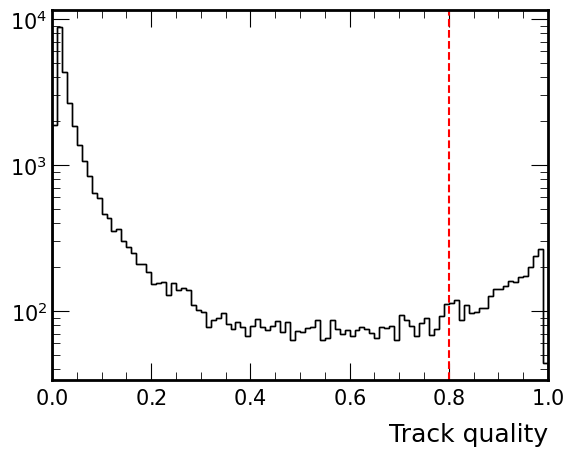

<Figure size 640x480 with 0 Axes>

In [6]:
plotter = Plot()

fig, ax = plt.subplots()

ax.axvline(0.8, color='red', linestyle='--', label='Cut')

plotter.plot_1D(
    ak.flatten(data["trk"]["trkqual.result"], axis=None),
    nbins=100, xmin=0, xmax=1,
    xlabel="Track quality", #title="Quality",
    stat_box=False,
    show=True,
    log_y=True,
    ax=ax
)

plt.tight_layout()
plt.show()

## In order

In [35]:
def define_cuts(data):
    """ Returns a dict of defined cuts."""

    # Tracker surfaces
    trk_front = selector.select_surface(data["trkfit"], sid=0)
    trk_mid = selector.select_surface(data["trkfit"], sid=1)
    trk_back = selector.select_surface(data["trkfit"], sid=2)
    in_trk = (trk_front | trk_mid | trk_back)
    data["in_trk"] = trk_front # useful for plotting
    data["at_trk_front"] = trk_front # useful for plotting
    
    # # 1. Electrons in tracker
    # is_electron = mask = (data["trkmcsim.pdg.pdg"] == self.particles["e-"]) #. selector.is_electron(data["trk"])
    # is_electron = selector.is_electron(data["trk"])
    # is_electron = ak.all(~in_trk | is_electron, axis=-1)
    # data["is_electron"] = is_electron # append
    # cut_manager.add_cut(
    #     name="is_electron",
    #     description="Electrons at tracker entrance according to track PDG",
    #     mask=is_electron
    # )

    # # 1. Truth track parent is electron 
    # is_electron = data["trkmc"]["trkmcsim"]["pdg"] == 11
    # is_trk_parent = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
    # is_trk_parent_electron = is_electron & is_trk_parent 
    # has_trk_parent_electron = ak.any(is_trk_parent_electron, axis=-1) # Any tracks with electron parents?

    # # trkmcsim-level definition, useful for plotting
    # data["is_trk_parent"] = is_trk_parent
    # data["is_trk_parent_electron"] = is_trk_parent_electron 
    # data["is_electron"] = has_trk_parent_electron 

    # # trk-level definition (the actual cut)
    # cut_manager.add_cut(
    #     name="is_electron", # call it "is_electron" for brevity
    #     description="Track parents are electrons (truth PID)", 
    #     mask=has_trk_parent_electron
    # )

    # # 2. Downstream tracks only through tracker
    # is_downstream = selector.is_downstream(data["trkfit"])

    #  # trkseg-level definition, useful for plotting
    # data["is_downstream_in_trk"] = is_downstream & trk_front 

    # # trk-level definition (the actual cut)
    # is_downstream = ak.all(~in_trk | is_downstream, axis=-1)
    # cut_manager.add_cut(
    #     name="is_downstream",
    #     description="Downstream tracks only (p_z > 0 through tracker)",
    #     mask=is_downstream
    # )
    
    # # 3. Minimum hits
    # has_hits = selector.has_n_hits(data["trk"], nhits=20)
    # cut_manager.add_cut(
    #     name="has_hits",
    #     description="Minimum of 20 active hits in the tracker",
    #     mask=has_hits
    # )

    # 4. Time at tracker entrance (trk level)
    within_t0 = ((640 < data["trkfit"]["trksegs"]["time"]) & 
                 (data["trkfit"]["trksegs"]["time"] < 1650))
    
    # trkseg-level definition, useful for plotting
    data["within_t0_at_trkent"] = within_t0 & trk_front 

    # trk-level definition (the actual cut)
    within_t0 = ak.all(~trk_front | within_t0, axis=-1)
    cut_manager.add_cut( # trk-level
        name="within_t0",
        description="t0 at tracker entrance (640 < t_0 < 1650 ns)",
        mask=within_t0
    )

    # 5. Track quality
    good_trkqual = selector.select_trkqual(data["trk"], quality=0.8)
    cut_manager.add_cut(
        name="good_trkqual",
        description="Track quality (quality > 0.8)",
        mask=good_trkqual
    )
    

cut_manager = CutManager(
    verbosity = 2
)
cuts = cut_manager.cuts
define_cuts(data)
cut_manager.print_cut_stats(data)



[pyselect] Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] Returning mask for trksegs with sid = 1 and sindex = 0
[pyselect] Returning mask for trksegs with sid = 2 and sindex = 0
[pyselect] Added cut within_t0 with index 0
[pyselect] Returning mask for trkqual > 0.8
[pyselect] Added cut good_trkqual with index 1

[pyselect] Cut Info:
----------------------------------------------------------------------------------------------------
Cut                  Events Passing       Absolute Frac. [%]   Relative Frac. [%]   Description                   
----------------------------------------------------------------------------------------------------
No cuts              6932                 100.00               100.00               No selection applied          
within_t0            1562                 22.53                22.53                t0 at tracker entrance (640 < t_0 < 1650 ns)
good_trkqual         27                   0.39                 1.73                 

In [39]:
# Make a copy
data_cut = ak.copy(data)

# Combine cuts
combined = cut_manager.combine_cuts() 
# data_cut["combined"] = combined

combined = cuts["within_t0"]["mask"]
# # Select tracks
data_cut["trk"] = data_cut["trk"][combined]
data_cut["trkfit"] = data_cut["trkfit"][combined]
data_cut["trkmc"] = data_cut["trkmc"][combined]

# Then clean up events with no tracks after cuts
combined = ak.any(combined, axis=-1)

data_cut = data_cut[combined] 

[pyplot] Initialised Plot with mu2e.mplstyle and verbosity = 1


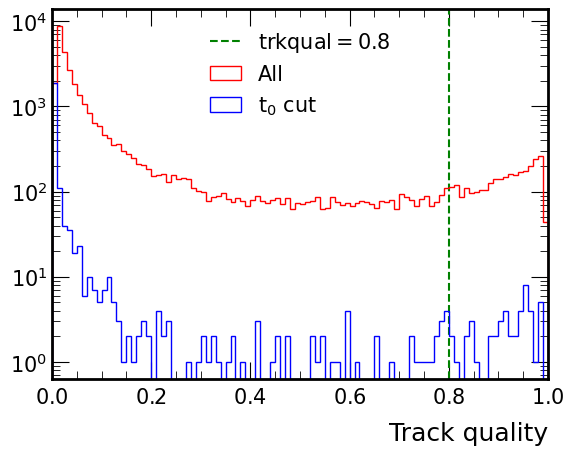

<Figure size 640x480 with 0 Axes>

In [40]:
plotter = Plot()

fig, ax = plt.subplots()

ax.axvline(0.8, color='green', linestyle='--', label='trkqual$=0.8$')

plotter.plot_1D_overlay(
    {
        "All" : ak.flatten(data["trk"]["trkqual.result"], axis=None),
        "$t_{0}$ cut" : ak.flatten(data_cut["trk"]["trkqual.result"], axis=None),
    },
    nbins=100, xmin=0, xmax=1,
    xlabel="Track quality", #title="Quality",
    log_y=True,
    ax=ax
)

plt.tight_layout()
plt.show()

## trkqual is not too harsh by itself, but it is quite harsh on the subset that pass t0